In [1]:
# Import all necessary tools

import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

from skimage import measure
import pandas as pd

from glob import glob
from tifffile import imread,imwrite

from stardist.models import StarDist3D
from pathlib import Path

from star3d.utils_3Dsegmentation import (  # noqa: E402
    patch_segmentation, norm_X,
    Hough_circle_3D, filter_regions_around_specific_voxel,
    sort_out_interfacing_regions,
    show_4d_with_contours, project_colours, project_inside_edge
)

C:\Users\ak2557\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Data directory and results directories

folder = './'
intensity_folder = 'intensity'
segmentation_results = 'STAR-3D_results'

if not os.path.isdir(folder + segmentation_results):
    os.makedirs(folder + segmentation_results)


## Automatic nuclei segmentation using STAR-3D

In [3]:
# Load intensity files and model

# Load intensity image files
input_files = sorted(glob(folder + intensity_folder + '/*.tif'))[:]

# Load model
model = StarDist3D.from_pretrained('STAR-3D')

Found model 'STAR-3D' for 'StarDist3D'.
Loading network weights from 'weights.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.234531, nms_thresh=0.3.


In [5]:
# Apply STAR-3D to the images
# This might take a very long time. There's a .py version of the segmentation part of the example script in src/ 
# for use on e.g. a cluster.

for file in input_files:
    
    print(file)
    
    # Name the output file (this is normally part of the intensity image file name)
    output_file_name = os.path.splitext(os.path.basename(file))[0][:]

    # Load image    
    intensity = imread(file,is_ome=False)
    
    # Normalise, downsample, and gamma correct image
    X_norm = norm_X(intensity,np.ones(3),1.0)

    # Apply STAR-3D 
    patches = np.array([1,1,1]) # Have only one patch, i.e. process as one image
    # Set margins where patches overlap to be bigger than the nuclei
    resolution = np.array([2.67,0.232,0.232])
    margins = 40/(resolution) # we expect the nuclei to be no more than 40 um in diameter
    
    # Apply STAR-3D and resample label map to the original resolution
    Y_pred = patch_segmentation(X_norm,model,patches,margins)

    # Separate different regions with the same label 
    # (although it shouldn't happen that two distinct regions have the same label, it's better to make sure)
    Y_pred = measure.label(Y_pred.astype(int), connectivity=2)
    
    # Save unfiltered result
    imwrite(folder + segmentation_results + '/' + output_file_name + '_label.tif', Y_pred.astype('uint16'), imagej=True, 
           resolution=1/resolution[1:3],
           metadata={
               'spacing': resolution[0],
               'unit': 'um',
               'axes': 'ZYX'
           })

./intensity\intensity_1.tif
[0, 0, 0]


583952714.py (32): <tifffile.imsave> is deprecated. Use tifffile.imwrite


./intensity\intensity_2.tif
[0, 0, 0]
./intensity\intensity_3.tif
[0, 0, 0]
./intensity\intensity_4.tif
[0, 0, 0]
./intensity\intensity_5.tif
[0, 0, 0]


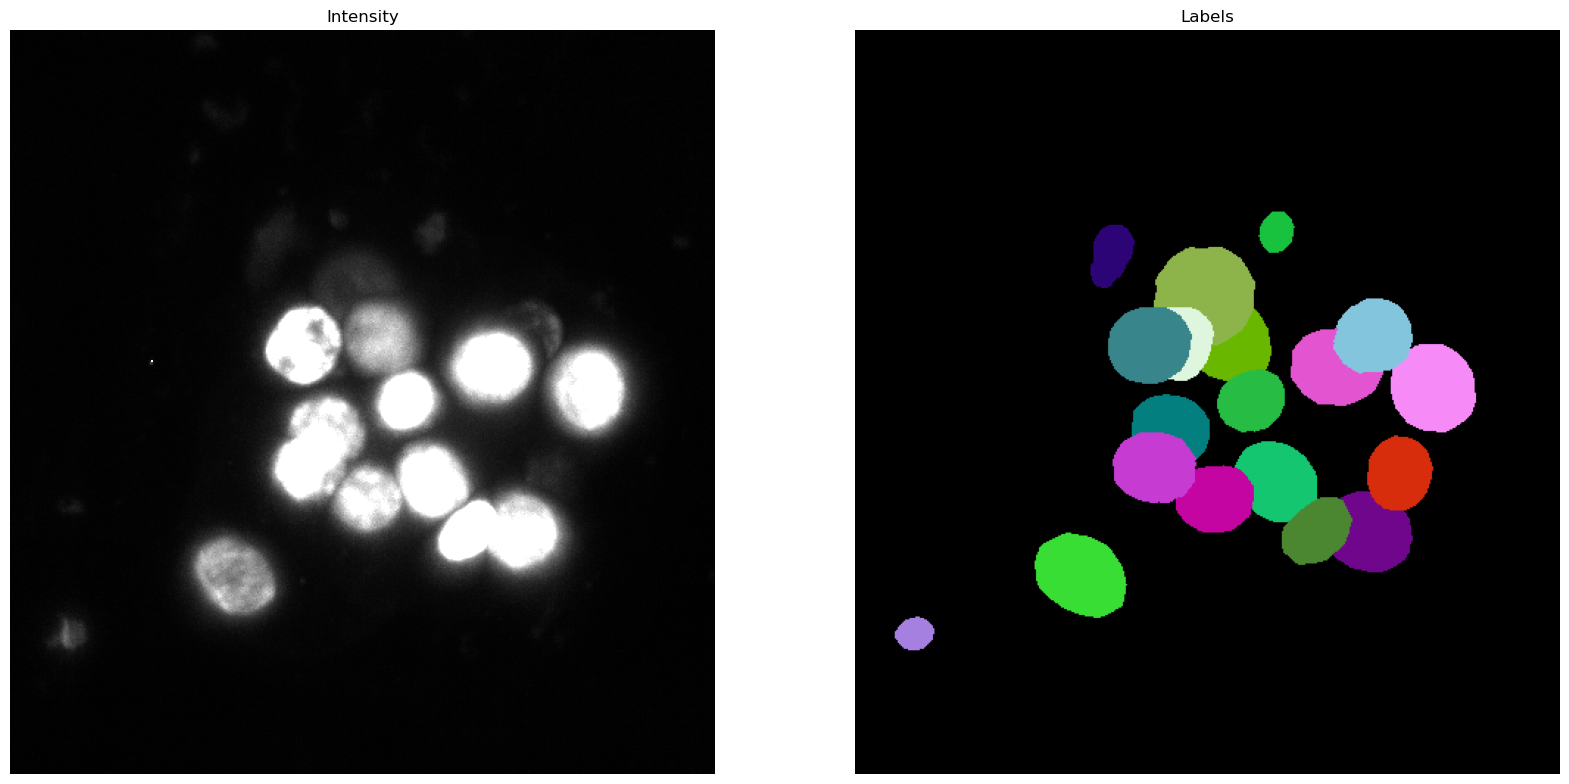

In [13]:
# Plot last result

fig,axs = plt.subplots(1,2)
fig.set_size_inches(20,10)
axs[0].set_title('Intensity')
axs[0].imshow(np.max(X_norm,axis=0),vmax=0.95, cmap='gray')
axs[0].set_axis_off()
axs[1].set_title('Labels')
axs[1].imshow(project_colours(Y_pred))
axs[1].set_axis_off()